In [18]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as sla
import scipy.constants as sc
import matplotlib.pyplot as plt
import matplotlib


#global values of constants
global hbar_
hbar_ = 1.0 #can be changed to scipy.constants.hbar
class wave:
    def __init__(self, mass, omega, n_, number_of_lattice_points = 500, xs_range = 10):
        
        self.m = mass
        self.om = omega
        self.n = n_
        self.xs_range = xs_range
        self.latice_points = number_of_lattice_points
        self.dx = self.xs_range / self.latice_points
        self.xs = np.linspace(-self.xs_range/2, self.xs_range/2, self.latice_points)
        
        self.V = self.harmonic_potential()
        self.psi, self.E_0_to_n = self.psi_num()
        
    def normalization_test(self):
        test_sum = 0.0
        for psi_n in self.psi:
            test_sum += psi_n
        test_sum *= self.dx
        return test_sum
        # print('c = ', test_sum)
        # print('error = ', "{:e}".format((np.abs(1 - test_sum) * 100)), '%')
        
    #Method for creation of harmonic potentials as numpy arrays
    def harmonic_potential(self):
        V = np.zeros(self.latice_points)
        for i in range(self.latice_points):
            V[i] = 1/2 * self.m * self.om**2 * self.xs[i]**2
        return V
    #The Python code used to construct H and calculate its eigenvectors and eigenvalues
    def schrodinger1D(self, neigs=20, findpsi=False):
        # create the Hamiltonian Operator matrix:
        H = sparse.eye(self.latice_points, self.latice_points, format='lil') * 2
        # implement the numerical derivative
        units = hbar_**2/self.m
        for i in range(self.latice_points - 1):
            H[i, i + 1] = -units
            H[i + 1, i] = -units
        H = H / (2 * self.dx ** 2)
        # Add in the potential energy V
        for i in range(self.latice_points):
            H[i, i] = H[i, i] + self.V[i]
        # convert to csc sparse matrix format:
        H = H.tocsc()
        # obtain neigs solutions from the sparse matrix:
        [evl, evt] = sla.eigs(H, k=neigs, which='SM')
        for i in range(neigs):
            # normalize the eigenvectors:
            evt[:, i] = evt[:, i] / np.sqrt(
                                    np.trapz(np.conj(
                                    evt[:,i])*evt[:,i],self.xs))
            # eigen values MUST be real:
            evl = np.real(evl)
        if findpsi == False:
            return evl
        else: 
            return evl, evt
    def psi_num(self):
        # call the 1D Schrodinger solver:
        H = self.schrodinger1D(self.n + 1, findpsi = True)
        evl = H[0] # energy eigenvalues
        evt = H[1] # eigenvectors
        indices = np.argsort(evl)
        n = indices[self.n]
        psi = np.real(np.conj(evt[:, n]) * evt[:, n])
        E = evl[indices]
        return psi, E
    #simply plots real and imaginary parts of the function
    def plot(self):
        fig = plt.figure(figsize = (16, 8))
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel(r'$x$', size = 25)
        ax1.xaxis.set_major_locator(plt.MultipleLocator(self.xs_range / 10))
        
        ax1.set_xlim([self.xs.min(), self.xs.max()])
        ax1.set_ylabel(r'$|\Psi(x)|^2 $', size = 25)
        

        ax1.plot(self.xs, self.psi, label = r'\rho(x)')
        
        ax1.set_ylim(bottom = 0)
        ax2 = ax1.twinx()
        ax2.set_ylabel(r'$V(x)$', size = 25)
        ax2.plot(self.xs, self.V, color = 'green')
        ax2.set_ylim(bottom = 0)
        plt.show()
    @staticmethod
    def plotDVR(points = 20, N = 1000, x_range = 20):
        T = np.empty(points)
        t = wave(1, 1, points, number_of_lattice_points = 2000, xs_range = 20)
        for i in range(points):
            ans = np.abs(t.E_0_to_n[i] - hbar_* t.om * (i + .5))
            ans /= hbar_*t.om
            T[i] = ans
        fig = plt.figure(figsize = (16, 8))
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel(r'$i$', size = 25)
        ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        ax1.set_xlim([0, points])
        
        ax1.set_ylabel(r'$[E_n-\hbar \omega\left(n+\frac{1}{2}\right)]/\hbar \omega $', size = 25)
        #ax1.set_ylim([0, T.max()])
        #ax1.set_yscale("log", base=10)
        ax1.set_ylim([0, T.max()])
        ax1.grid(which = 'major', axis = 'y')
        ax1.plot(T, 'go')
        plt.show()

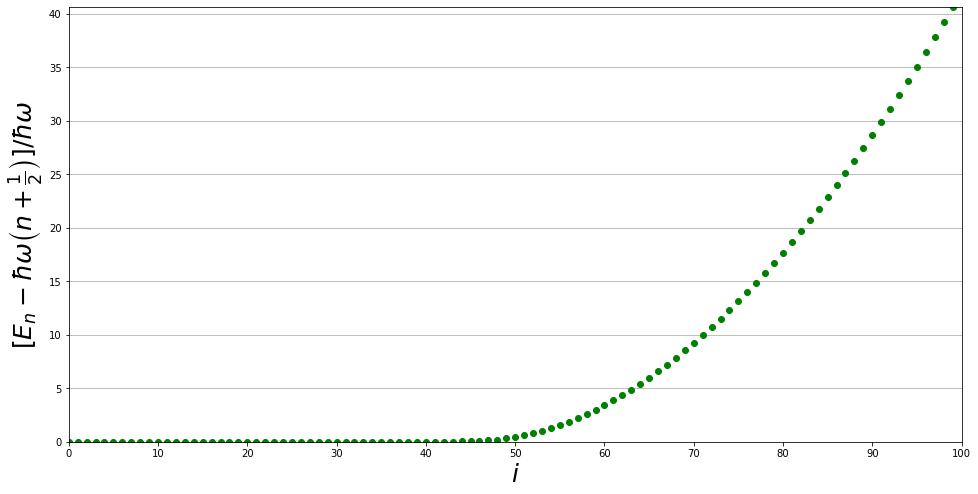

In [19]:
wave.plotDVR(100, N = 2000, x_range = 32)

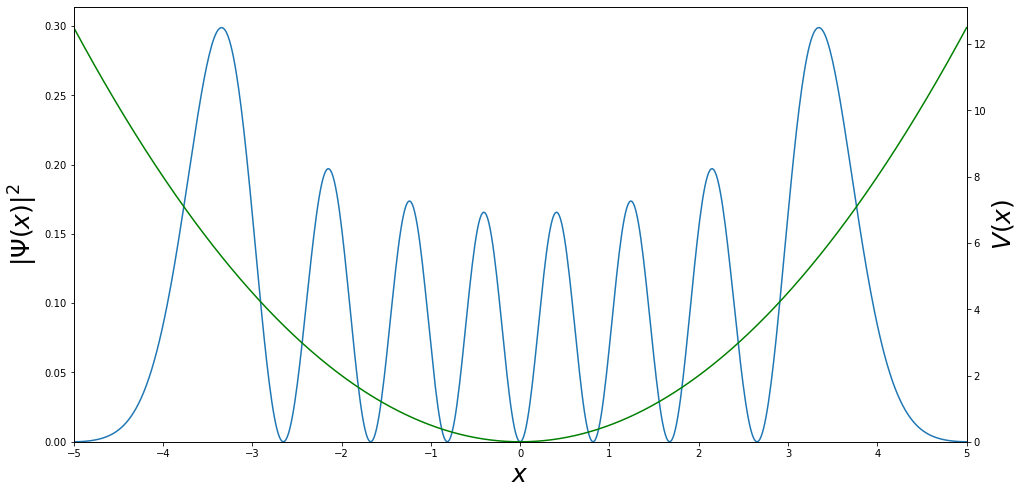

In [14]:
wave(1, 1, 7, number_of_lattice_points=700, xs_range=10).plot()